<a href="https://colab.research.google.com/github/shazoop/KG-Embeddings/blob/main/Paper1_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import numpy as np
import random as rand

In [2]:
def vertex_code(dim, num):
  codebook = np.zeros((num,dim))
  for i in range(num):
    code = np.random.multivariate_normal(np.zeros(dim),np.eye(dim))
    code = code/np.linalg.norm(code)
    codebook[i] = code
  return(codebook)

In [3]:
A = vertex_code(4,3)

In [4]:
A

array([[-0.17241161,  0.16324207, -0.79094164,  0.5639482 ],
       [-0.28891552,  0.56220736,  0.5270272 , -0.56806077],
       [-0.42881342, -0.12753136, -0.88351473,  0.13876786]])

In [47]:
dim = 16
num = 64

codebook = vertex_code(dim,num)

special_code = vertex_code(dim,2)

edge_code = vertex_code(dim,3)

In [28]:
def generate_graph(codebook, num_edges):
  n,d = codebook.shape[0], codebook.shape[1]
  graph = 0
  for i in range(num_edges):
    d_ix, c_ix = rand.randint(0,n-1), rand.randint(0,n-1)
    dom, cod = codebook[d_ix], codebook[c_ix]
    graph  = graph + np.einsum('i,j -> ij', dom, cod)
  return(graph)


In [29]:
def generate_edge(special_code):
  edge = np.einsum('i,j -> ij', special_code[0], special_code[1])
  return(edge)

In [34]:
def correct_edgeQ(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges) + generate_edge(special_code)
    edgeQ = np.einsum('i,ij,j ->',special_code[0],curr_graph, special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [35]:
correct_edgeQ(codebook, special_code, 24, 100)

1.0137894949283066

In [36]:
def incorrect_edgeQ(codebook, special_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges)
    edgeQ = np.einsum('i,ij,j ->',special_code[0],curr_graph, special_code[1])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [37]:
incorrect_edgeQ(codebook, special_code, 24, 100)

0.0486243619423517

In [58]:
def edge_composition(graph1,graph2):
  composed_graph = np.einsum('ij,jk -> ik',graph1,graph2)
  return(composed_graph)

def correct_compQ(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges) + generate_edge(edge_code[:2]) + generate_edge(edge_code[1:3])
    curr_graph = edge_composition(curr_graph,curr_graph)
    edgeQ = np.einsum('i,ij,j ->',edge_code[0],curr_graph, edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

def incorrect_compQ(codebook, edge_code, num_edges, num_trials):
  avg_score = 0
  for step in range(num_trials):
    curr_graph = generate_graph(codebook,num_edges)
    curr_graph = edge_composition(curr_graph,curr_graph)
    edgeQ = np.einsum('i,ij,j ->',edge_code[0],curr_graph, edge_code[2])
    avg_score = avg_score + edgeQ
  avg_score = avg_score/num_trials
  return(avg_score)

In [59]:
correct_compQ(codebook, edge_code, 24, 100)

0.9871014058820269

In [60]:
incorrect_compQ(codebook, edge_code, 24, 100)

0.019038423304525837

In [113]:
import matplotlib.pyplot as plt
import math

In [115]:
def testing(vertex_dim, vertex_num, edge_list, num_trials):
  codebook = vertex_code(vertex_dim,vertex_num)
  special_code = vertex_code(vertex_dim,2)
  edge_code = vertex_code(vertex_dim,3)
  cor_edgeQ = []
  incor_edgeQ = []
  cor_compQ = []
  incor_compQ = []
  for num_edge in edge_list:
    cor_edgeQ.append(abs(correct_edgeQ(codebook, special_code, num_edge, num_trials)-1))
    incor_edgeQ.append(abs(incorrect_edgeQ(codebook, special_code, num_edge, num_trials)))
    cor_compQ.append(abs(correct_compQ(codebook, edge_code, num_edge, num_trials)-1))
    incor_compQ.append(abs(incorrect_compQ(codebook, edge_code, num_edge, num_trials)))
  return cor_edgeQ, incor_edgeQ, cor_compQ, incor_compQ

In [116]:
edge_list = [8,16,24,32,48,64,80,128,240,400,560,800]

In [117]:
vertex_dim = 16
vertex_num = 64
num_trials = 500

In [118]:
cor_edgeQ, incor_edgeQ, cor_compQ, incor_compQ = testing(vertex_dim, vertex_num, edge_list, num_trials)

In [119]:
cor_edgeQ

[0.003444488778152399,
 0.009955147168230871,
 0.0019778958365177512,
 0.02503830838711274,
 0.025927039081875325,
 0.04367127455383024,
 0.025426160709529744,
 0.008155876551620533,
 0.04930407189080199,
 0.07100027884224469,
 0.18871891458328416,
 0.22796305695349472]

In [120]:
incor_edgeQ

[0.009530579315945654,
 0.010442829070172032,
 0.011070775604820334,
 0.013441744166278836,
 0.010504865256810077,
 0.025915520114596233,
 0.024833704447932203,
 0.0413088023716839,
 0.061011223568658006,
 0.13555413301416988,
 0.22098872158302896,
 0.14260617480002447]

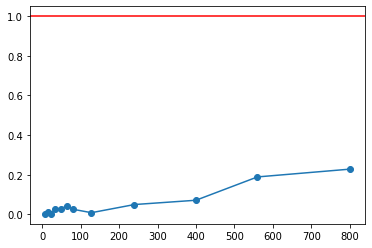

In [126]:
plt.plot(edge_list,cor_edgeQ, marker = 'o')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

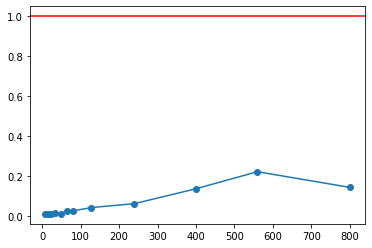

In [129]:
plt.plot(edge_list,incor_edgeQ, marker = 'o')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

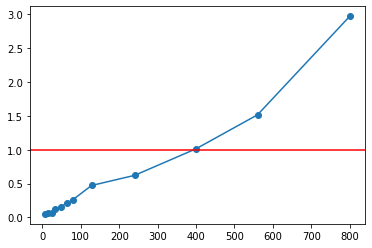

In [128]:
plt.plot(edge_list,cor_compQ, marker = 'o')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

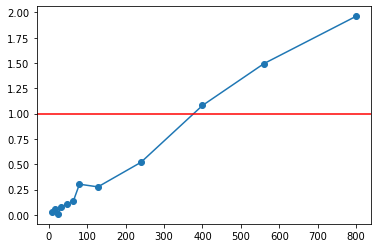

In [127]:
plt.plot(edge_list,incor_compQ, marker = 'o')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()